In [1]:
from agents.dqn import DQNAgent
from agents.sac import SACAgent
from envs.LinearBertrandInflation import LinearBertrandEnv
from envs.BertrandInflation import BertrandEnv
from replay_buffer import ReplayBuffer
import numpy as np
from tqdm import tqdm
import sys

N = 3
k = 2
rho = 2e-4
#rho = 0.0
timesteps = 500
buffer_size = 200_000
sample_size = 256
update_steps = 1
deviate_start = 0.8
deviate_end = 0.9
random_seed = 3380

np.random.seed(random_seed)

variation = 'base'

dim_states = (N * k) + k + 1
dim_actions = 15
#dim_actions = 1

#env = LinearBertrandEnv(N, k, rho, timesteps, dim_actions=dim_actions)
env = BertrandEnv(N, k, rho, timesteps, dim_actions=dim_actions, max_var=2.0, mu = 0.25,
                  random_state = 3380, use_inflation_data=True, normalize=False)
buffer = ReplayBuffer(dim_states, N, buffer_size, sample_size)

agents = [DQNAgent(dim_states, dim_actions, beta = 5e-5, lr = 1e-1) for _ in range(N)]
#agents = [SACAgent(dim_states, dim_actions) for _ in range(N)]

exp_name = 'dqn_experiment'
episodes = 1

prices_history = np.zeros((episodes, timesteps, N))
actions_history = np.zeros((episodes, timesteps, N))
costs_history = np.zeros((episodes, timesteps))
monopoly_history = np.zeros((episodes, timesteps))
nash_history = np.zeros((episodes, timesteps))
rewards_history = np.zeros((episodes, timesteps, N))
delta_history = np.zeros((episodes, timesteps))
quantities_history = np.zeros((episodes, timesteps, N))
pi_N_history = np.zeros((episodes, timesteps))
pi_M_history = np.zeros((episodes, timesteps))
A_history = np.zeros((episodes, timesteps))

ob_t = env.reset()
for episode in range(episodes):
    for t in range(timesteps):
        
        actions = [agent.select_action(ob_t) for agent in agents]
        
        if variation == 'deviate':
            if (t/timesteps > deviate_start) and (t/timesteps <= deviate_end):
                env.trigger_deviation = True
            
            elif t/timesteps > deviate_end:
                env.trigger_deviation = False
        
        elif variation == 'altruist':
            env.altruist = True
        
        ob_t1, rewards, done, info = env.step(actions)
        
        experience = (ob_t, actions, rewards, ob_t1, done)
        
        buffer.store_transition(*experience)
        
        if (t % update_steps == 0) & (t >= buffer.sample_size):
            for agent_idx in range(N):
                agent = agents[agent_idx]
                sample = buffer.sample(agent_idx)
                agent.update(*sample)
                
        sys.stdout.write(f"\rExperiment: {exp_name} \t Episode: {episode + 1}/{episodes} \t Episode completion: {100 * t/timesteps:.2f} % \t Delta: {info:.2f}")
                
        ob_t = ob_t1
        
    # store episode metrics
    prices_history[episode] = np.array(env.prices_history)[-timesteps:]
    actions_history[episode] = np.array(env.action_history)[-timesteps:]
    costs_history[episode] = np.array(env.costs_history)[-timesteps:]
    monopoly_history[episode] = np.array(env.monopoly_history)[-timesteps:]
    nash_history[episode] = np.array(env.nash_history)[-timesteps:]
    rewards_history[episode] = np.array(env.rewards_history)[-timesteps:]
    delta_history[episode] = np.array(env.metric_history)[-timesteps:]
    quantities_history[episode] = np.array(env.quantities_history)[-timesteps:]
    pi_N_history[episode] = np.array(env.pi_N_history)[-timesteps:]
    pi_M_history[episode] = np.array(env.pi_M_history)[-timesteps:]
    A_history[episode] = np.array(env.A_history)[-timesteps:]

prices_history = np.mean(prices_history, axis = 0)
actions_history = np.mean(actions_history, axis = 0)
costs_history = np.mean(costs_history, axis = 0)
monopoly_history = np.mean(monopoly_history, axis = 0)
nash_history = np.mean(nash_history, axis = 0)
rewards_history = np.mean(rewards_history, axis = 0)
delta_history = np.mean(delta_history, axis = 0)
quantities_history = np.mean(quantities_history, axis = 0)
pi_N_history = np.mean(pi_N_history, axis = 0)
pi_M_history = np.mean(pi_M_history, axis = 0)
A_history = np.mean(A_history, axis = 0) # equal disposition to pay

Experiment: dqn_experiment 	 Episode: 1/1 	 Episode completion: 99.80 % 	 Delta: -0.74

In [2]:
import torch

state, action, reward, state_t1, done = buffer.sample(1)

device = 'cpu'

state = torch.tensor(state).to(device)
action = torch.tensor(action, dtype = int).unsqueeze(1).to(device)
reward = torch.tensor(reward).unsqueeze(1).to(device)
state_t1 = torch.tensor(state_t1).to(device)
done = torch.tensor(done).unsqueeze(dim = 1).to(device)

state.shape

torch.Size([256, 9])

In [3]:
batch_size = 256
agent = 2

prices_costs = state[:, 1:-k].reshape(batch_size, k, N) # take just prices - costs
self_price = np.expand_dims(prices_costs[:, :, agent], 1) # gather own series
other_prices = np.delete(prices_costs, agent, axis = 2) # gather rest of series

cost_t = np.expand_dims(state[:, 0], 1)
past_costs = state[:, -k:]

In [5]:
state, action, reward, state_t1, done = buffer.sample(1)

batch_size = 256
agent = 2

prices_costs = state[:, 1:-k].reshape(batch_size, k, N) # take just prices - costs
#self_price = np.expand_dims(prices_costs[:, :, agent], 1) # gather own series
self_price = prices_costs[:, :, agent] # gather own series
other_prices = np.delete(prices_costs, agent, axis = 2) # gather rest of series

cost_t = np.expand_dims(state[:, 0], 1)
past_costs = state[:, -k:]

# forward con (self_price, other_prices, cost_t, past_costs)
import torch
self_price = torch.tensor(self_price)
other_prices = torch.tensor(other_prices)
cost_t = torch.tensor(cost_t)
past_costs = torch.tensor(past_costs)

other_prices.shape

torch.Size([256, 2, 2])

In [49]:
prices_costs = state[1:-k].reshape(k, N)
prices_costs

array([[-0.956483  ,  0.86063266, -0.95677406],
       [-0.20202208,  0.56435466, -1.4560893 ]], dtype=float32)

In [51]:
agent = 2

prices_costs = state[1:-k].reshape(k, N) # take just prices - costs
self_price = np.expand_dims(prices_costs[:, agent], 1) # gather own series
other_prices = np.delete(prices_costs, agent, axis = 1) # gather rest of series

np.concatenate([self_price, other_prices], axis = 1) # concatenate

array([[-0.95677406, -0.956483  ,  0.86063266],
       [-1.4560893 , -0.20202208,  0.56435466]], dtype=float32)

In [30]:
from utils.plot_metrics import get_rolling, get_rolling_std
import pandas as pd

## EXPORT
results = pd.DataFrame({'costs': costs_history,
                        'pi_N': pi_N_history,
                        'pi_M': pi_M_history,
                        'delta': delta_history,
                        'p_nash': nash_history,
                        'p_monopoly': monopoly_history,
                        'A': A_history,
                        })

for agent in range(env.N):
    results[f'actions_{agent}'] = actions_history[:, agent]
    results[f'prices_{agent}'] = prices_history[:, agent]
    results[f'quantities_{agent}'] = quantities_history[:, agent]
    results[f'rewards_{agent}'] = rewards_history[:, agent]
    
results.to_csv(f'test2.csv', index = False, sep = ';', encoding = 'utf-8-sig')

## READ AND PREPARE
window_size = 1000
df_avg = pd.DataFrame()
df_std = pd.DataFrame()

df_plot = pd.read_csv('test2.csv', sep = ';', encoding = 'utf-8-sig')

actions_cols = [col for col in df_plot.columns if 'actions' in col]
price_cols = [col for col in df_plot.columns if 'prices' in col]
rewards_cols = [col for col in df_plot.columns if 'rewards' in col]
quantities_cols = [col for col in df_plot.columns if 'quantities' in col]

n_agents = len(actions_cols)

df_plot['avg_actions'] = df_plot[actions_cols].mean(axis = 1)
df_plot['avg_prices'] = df_plot[price_cols].mean(axis = 1)
df_plot['avg_rewards'] = df_plot[rewards_cols].mean(axis = 1)
df_plot['avg_quantities'] = df_plot[quantities_cols].mean(axis = 1)
avg_cols = [col for col in df_plot.columns if 'avg' in col]

window_cols = price_cols + rewards_cols + quantities_cols + avg_cols + ['delta']
for col in window_cols:
    df_avg[col] = get_rolling(df_plot[col], window_size = window_size)
    df_std[col] = get_rolling_std(df_plot[col], window_size = window_size)

series_size = df_avg.shape[0]

df_plot.tail()

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1,avg_actions,avg_prices,avg_rewards,avg_quantities
19995,1.055276,0.299471,0.343706,0.542517,1.854747,2.242688,2.055276,0.649339,2.425741,0.174865,0.239647,0.421086,1.944001,0.458287,0.407291,0.535213,2.184871,0.323469,0.316576
19996,1.055276,0.299471,0.343706,-0.450465,1.854747,2.242688,2.055276,0.362506,1.820364,0.355844,0.272252,0.322272,1.735448,0.421713,0.286837,0.342389,1.777906,0.279545,0.388779
19997,1.055276,0.299471,0.343706,-5.382939,1.854747,2.242688,2.055276,0.360545,1.816226,0.161268,0.122716,-0.312670,1.055276,0.738753,0.000000,0.023938,1.435751,0.061358,0.450010
19998,1.055276,0.299471,0.343706,-6.115305,1.854747,2.242688,2.055276,0.742171,2.621667,0.036980,0.057924,-0.263691,1.055276,0.848226,0.000000,0.239240,1.838472,0.028962,0.442603
19999,1.055276,0.299471,0.343706,-5.470453,1.854747,2.242688,2.055276,0.195843,1.468613,0.278161,0.114974,-0.101934,1.055276,0.635793,0.000000,0.046954,1.261945,0.057487,0.456977


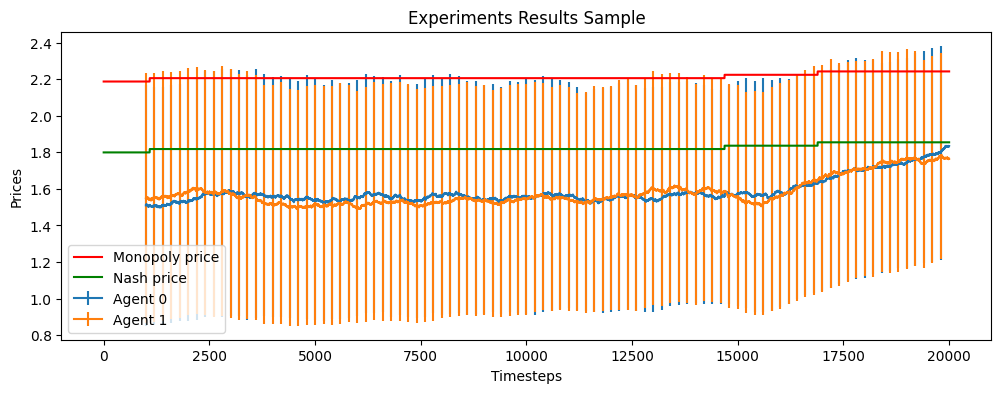

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
for agent in range(n_agents):
    serie = f'prices_{agent}'
    #plt.plot(price_serie, label = f'Agent {agent}')
    plt.errorbar(range(series_size), df_avg[serie], df_std[serie], errorevery=int(0.01 * series_size), label = f'Agent {agent}')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.title('Experiments Results Sample')
plt.legend()
plt.savefig('prices.png')

Text(0.5, 1.0, 'Standard Deviation of Agent 0')

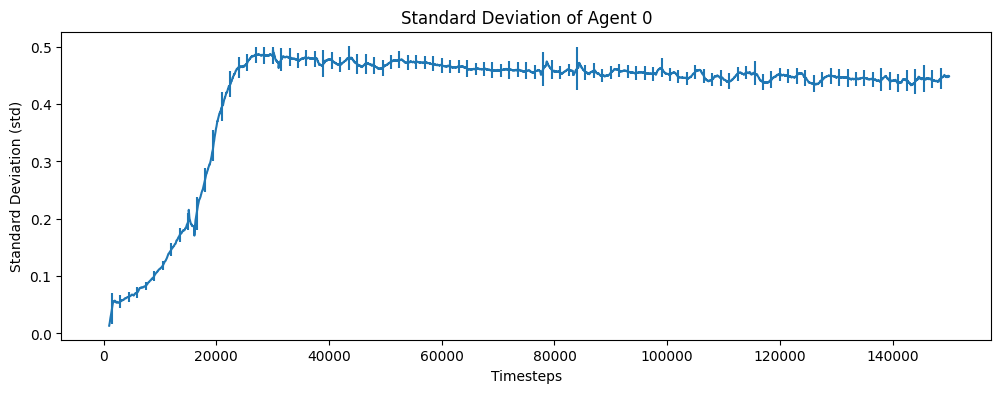

In [24]:
window_size = 1000
std_avg = get_rolling(agents[0].mean_history, window_size)
std_std = get_rolling_std(agents[0].mean_history, window_size)

std_size = len(std_std)

plt.figure(figsize = (12, 4))
plt.errorbar(range(std_size), std_avg, std_std, errorevery=int(0.01 * std_size))
plt.xlabel('Timesteps')
plt.ylabel('Standard Deviation (std)')
plt.title('Standard Deviation of Agent 0')
#plt.savefig('desviacion_estandar.png')

Text(0.5, 1.0, 'Standard Deviation of Agent 0')

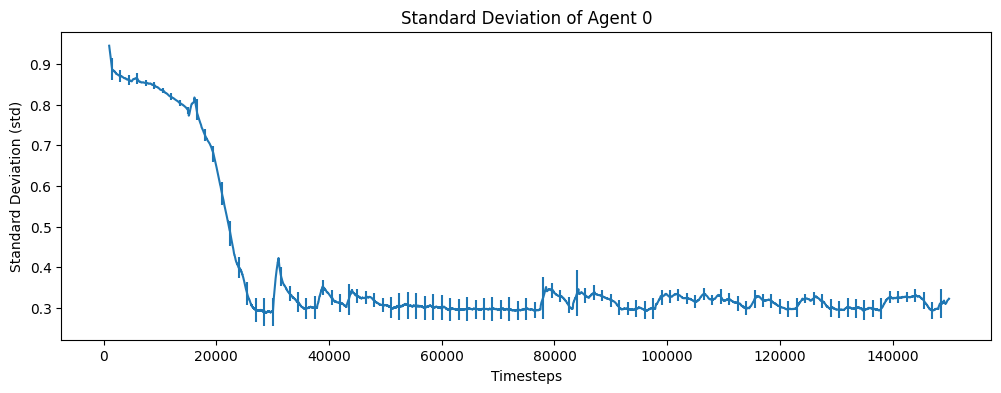

In [25]:
window_size = 1000
std_avg = get_rolling(agents[0].std_history, window_size)
std_std = get_rolling_std(agents[0].std_history, window_size)

std_size = len(std_std)

plt.figure(figsize = (12, 4))
plt.errorbar(range(std_size), std_avg, std_std, errorevery=int(0.01 * std_size))
plt.xlabel('Timesteps')
plt.ylabel('Standard Deviation (std)')
plt.title('Standard Deviation of Agent 0')
#plt.savefig('desviacion_estandar.png')

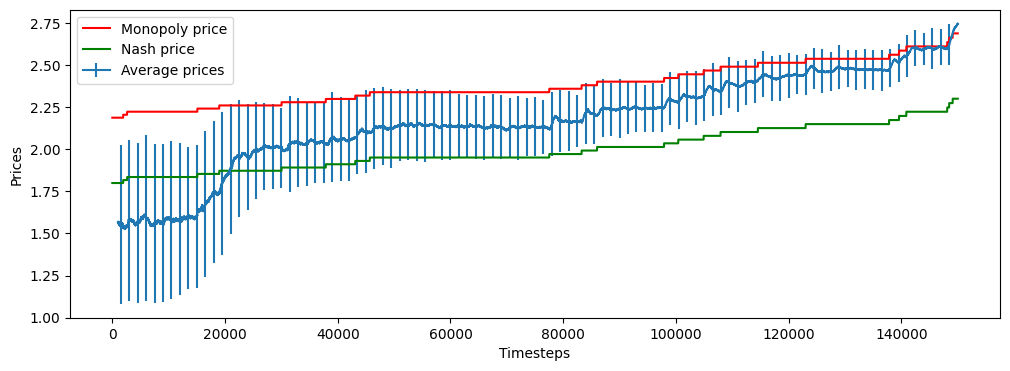

In [26]:
import matplotlib.pyplot as plt

size = len(df_avg[serie])
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['avg_prices'], label = 'Average prices')
plt.errorbar(range(series_size), df_avg['avg_prices'], df_std['avg_prices'], errorevery=int(0.01 * series_size), label = f'Average prices')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

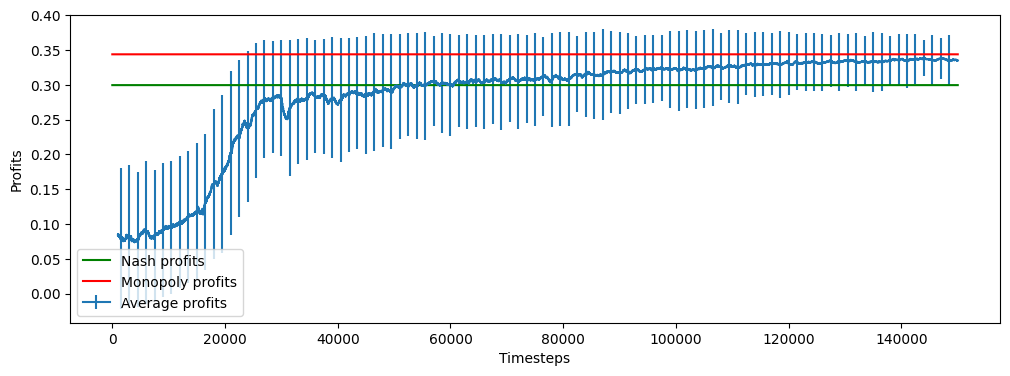

In [27]:
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['avg_rewards'], label = 'Average profits')
plt.errorbar(range(series_size), df_avg['avg_rewards'], df_std['avg_rewards'], errorevery=int(0.01 * series_size), label = f'Average profits')
plt.plot(df_plot['pi_N'], label = 'Nash profits', color = 'green')
plt.plot(df_plot['pi_M'], label = 'Monopoly profits', color = 'red')
plt.xlabel('Timesteps')
plt.ylabel('Profits')
plt.legend()

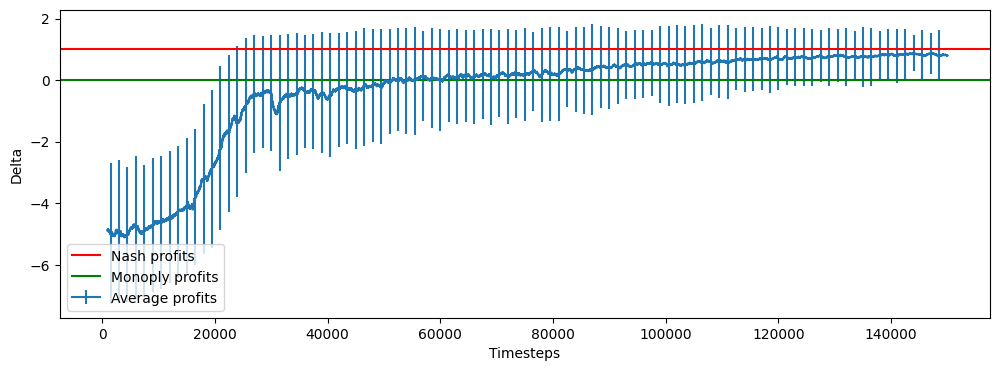

In [28]:
plt.figure(figsize = (12, 4))
#plt.plot(df_plot['delta'], label = 'Average profits')
plt.errorbar(range(series_size), df_avg['delta'], df_std['delta'], errorevery=int(0.01 * series_size), label = f'Average profits')
plt.axhline(1, color = 'red', label = 'Nash profits')
plt.axhline(0, color = 'green', label = 'Monoply profits')
plt.xlabel('Timesteps')
plt.ylabel('Delta')
plt.legend()

In [ ]:
import pandas as pd
import numpy as np

sample_size = 10

df  = pd.read_csv('test2.csv', sep = ';')
df = df.iloc[8000:8000 + sample_size]
df['rewards_0'] = df['rewards_0'].replace(0, np.nan)
df['rewards_1'] = df['rewards_1'].replace(0, np.nan)

df = df.dropna()
df

In [ ]:
import matplotlib.pyplot as plt
# Crea un histograma para la columna
plt.hist(df['prices_0'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios')
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
# Crea un histograma para la columna
plt.hist(df['rewards_0'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Recompensas')
plt.grid(True)

In [ ]:
rolling_df = df.rolling(10).mean().dropna()
rolling_df = rolling_df[['prices_0', 'p_nash', 'p_monopoly', 'rewards_0', 'pi_N', 'pi_M']]
rolling_df.head()

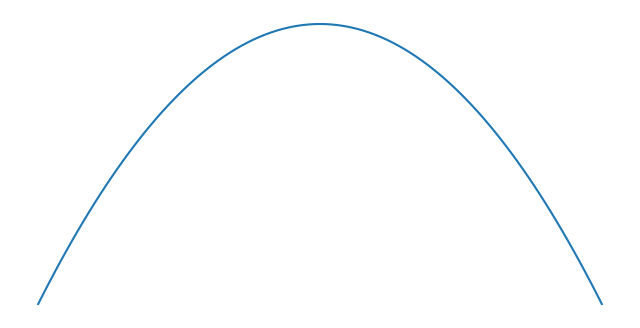

In [59]:
import pandas as pd
import numpy as np

A = 2
c = 1
epsilon = 1

prices = np.arange(1, 2.01, 0.01)

pi_list = []
for p in prices:
    q = A - epsilon * p
    pi = (p - c) * q
    
    pi_list.append(pi)
    
import matplotlib.pyplot as plt

# Filtrar valores mayores o iguales a 0 en el eje Y
filtered_pi_list = [pi if pi >= 0 else 0 for pi in pi_list]

plt.figure(figsize = (8, 4))
plt.plot(prices, filtered_pi_list)
plt.xlabel("$p_{i,t}$")
plt.ylabel("$R_{i,t}$")
#plt.title("Revenue maximization curve")
#plt.axvline(1.5, linestyle = '--', color = 'red')
#plt.axvline(2, linestyle = '--', color = 'green')
#plt.ylim(0, 0.252)

plt.axis('off')
plt.xticks([])  # Oculta las etiquetas del eje X
plt.yticks([])  # Oculta las etiquetas del eje Y
plt.savefig('demmand_curve.png')
plt.show()

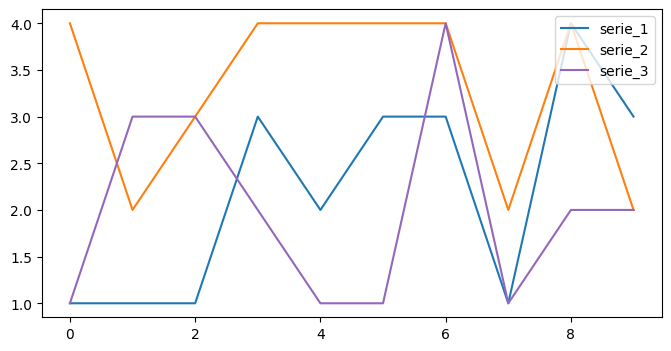

In [72]:
import numpy as np
import matplotlib.pyplot as plt

serie_1 = np.random.randint(1, 5, 10)
serie_2 = np.random.randint(1, 5, 10)
serie_3 = np.random.randint(1, 5, 10)

plt.figure(figsize = (8, 4))
plt.plot(serie_1, color = 'C0', label = 'serie_1')
plt.plot(serie_2, color = 'C1', label = 'serie_2')
plt.plot(serie_3, color = 'C4', label = 'serie_3')
plt.legend(loc = 'upper right')

In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

env = 'linear'
parameters = ['N', 'gamma', 'rho', 'lr', 'k']

metrics = os.listdir('metrics')
metrics = [metric for metric in metrics if (env in metric) and ('altruist' not in metric) and ('deviate' not in metric)]
metrics += ['linear_sac_base_1_altruist.csv']

delta_base = pd.read_csv('metrics/linear_sac_base_1.csv', sep = ';')['delta']

results = {}
for metric in metrics:
    
    df_metric = pd.read_csv(f'metrics/{metric}', sep = ';')
    delta_metric = df_metric['delta']
    avg_delta = np.round(np.mean(delta_metric), 2)
    
    t_statistic, p_value = stats.ttest_ind(delta_base, delta_metric)
    p_value = np.round(p_value, 2)
    
    results[metric] = [avg_delta, p_value]
    
df_results = pd.DataFrame(results.values(), index = results.keys(), columns=['Delta', 'p_value'])
df_results = df_results.sort_values(by = 'Delta', ascending = False)

df_results

,Delta,p_value
linear_sac_gamma_2_1.csv,0.43,0.00
linear_sac_k_2_1.csv,0.42,0.00
linear_sac_rho_2_1.csv,0.41,0.00
linear_sac_rho_1_1.csv,0.39,0.00
linear_sac_gamma_1_1.csv,0.34,0.00
linear_sac_lr_2_1.csv,0.17,0.31
linear_sac_base_1.csv,0.17,1.00
linear_sac_lr_1_1.csv,0.15,0.00
linear_sac_k_1_1.csv,0.12,0.00
linear_sac_base_1_altruist.csv,0.05,0.00


In [36]:
import os

metrics = os.listdir(f'metrics/')

parameters = ['N', 'gamma', 'rho', 'lr', 'k']
envs = list(set([metric.split('_')[0] for metric in metrics if '.csv' in metric]))
models = list(set([metric.split('_')[1] for metric in metrics if '.csv' in metric]))
for env in envs:
    env_metrics = [metric for metric in metrics if env in metric]
    for model in models:
        model_metrics = [metric for metric in env_metrics if model in metric]
        base_metric = f'{env}_{model}_base_1.csv'
        for parameter in parameters:
            final_metrics = sorted([metric for metric in model_metrics if parameter in metric])
            
            if base_metric in metrics:
                final_metrics = sorted(final_metrics + [f'{env}_{model}_base_1.csv'])

            print(f'final_metrics: {final_metrics}')

final_metrics: ['linear_sac_N_1_base_1.csv', 'linear_sac_N_2_base_1.csv', 'linear_sac_base_1.csv']
final_metrics: ['linear_sac_base_1.csv', 'linear_sac_gamma_1_base_1.csv', 'linear_sac_gamma_2_base_1.csv']
final_metrics: ['linear_sac_base_1.csv', 'linear_sac_rho_1_base_1.csv', 'linear_sac_rho_2_base_1.csv']
final_metrics: ['linear_sac_base_1.csv', 'linear_sac_lr_1_base_1.csv', 'linear_sac_lr_2_base_1.csv']
final_metrics: ['linear_sac_base_1.csv', 'linear_sac_k_1_base_1.csv', 'linear_sac_k_2_base_1.csv']
